In this notebook, I want to poke at an idea for a more "sensitive" likelihood function for box configurations -- render-and-compare (comparing the rendered hypothesized config and the observed configs that contributed to the cluster).

More precisely: we have a hypothesized shape + pose of a box. For each camera, render an "expected" descriptor image for the box in that configuration, and take the difference between it and the real descriptor image from that camera.

That math does not count for occlusions or the background, so mask out the area that is not inside the hypothesized box extent, as well as area that is not in the predicted foreground for this object from maskrcnn.

In [46]:
%load_ext autoreload
%autoreload 2

import community as community_louvain
from copy import deepcopy
from collections import OrderedDict
import cv2
import copy
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import point_cloud_utils as pcu
import torch
import torch.nn.functional as F
from skimage.transform import resize
from skimage.color import rgb2gray
from tqdm.autonotebook import tqdm
import moderngl
import trimesh.creation
from pyrr import Matrix44
from PIL import Image
from objloader import Obj

import torch
import torchvision

import dense_correspondence_manipulation.utils.utils as utils

import meshcat
import meshcat.geometry as g

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.config import CfgNode as CN
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.data.datasets import load_coco_json
from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, launch
from detectron2.evaluation import inference_on_dataset, COCOEvaluator
from detectron2.modeling import build_model
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer


import scene_generation.inverse_graphics.synthetic_scene_database_loader as loader
from scene_generation.inverse_graphics.synthetic_scene_database_loader import XenRCNNMapper
import scene_generation.inverse_graphics.keypoint_mcmc.roi_heads as roi_heads
from scene_generation.inverse_graphics.keypoint_mcmc.particle_filter_icp import *
from scene_generation.inverse_graphics.render_target_descriptor_maps import render_single_box_descriptor_image
from scene_generation.utils.type_convert import (
    transform_from_pose_vector, dict_to_matrix,
    rigidtransform_from_pose_vector
)

np.set_printoptions(precision=2)
torch.set_default_tensor_type(torch.FloatTensor)

DATA_ROOT = "/home/gizatt/data/generated_cardboard_envs/"
DETECTRON_ROOT = "/home/gizatt/tools/detectron2/"


class InstanceCloud():
    def __init__(self, pts, colors, descriptors):
        self.pts = pts
        self.descriptors = descriptors
        self.colors = colors
    def get_augmented_pts(self, descriptor_factor=1.):
        return np.vstack([self.pts, descriptor_factor*self.descriptors])
    
%matplotlib inline
def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    
vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")["rendering_score_function"]
vis.delete()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [47]:
# Create the dataset loader so we can get our test scene
from detectron2.data import DatasetCatalog, MetadataCatalog
from scene_generation.inverse_graphics.synthetic_scene_database_loader import load_xencoco_json

DatasetCatalog.clear()
def load_dataset(d):
    return load_xencoco_json(
        os.path.join(DATA_ROOT, "%s.json" % (d)),
        data_root=DATA_ROOT,
        dataset_name="synthetic_%s" % d)
def load_real_dataset():
    return load_coco_json(
        "/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json",
        image_root="/home/gizatt/data/coco/cardboard_boxes_in_wild/images",
        dataset_name="prime_boxes_real", extra_annotation_keys=None)
for d in ["train", "test"]:
    DatasetCatalog.register("synthetic_" + d, lambda d=d: load_dataset(d))
DatasetCatalog.register("prime_boxes_real", load_real_dataset)
synthetic_train_metadata = MetadataCatalog.get("synthetic_train")
real_prime_boxes_metadata = MetadataCatalog.get("prime_boxes_real")
real_prime_boxes_metadata.set(json_file="/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json")
print("Metadata train: ", synthetic_train_metadata)
print("Metadata real: ", real_prime_boxes_metadata)
DatasetCatalog.register("synthetic_5_types", lambda: load_dataset("scene_groups_5_types"))

cfg = get_cfg()
cfg.merge_from_file(os.path.join(DETECTRON_ROOT, "configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.INPUT.MIN_SIZE_TRAIN = (480)
cfg.INPUT.MIN_SIZE_TEST = (480)
cfg.INPUT.DEPTH_FORMAT = 'L'
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

cfg.DATASETS.TRAIN = ("synthetic_train",)
cfg.DATASETS.TEST = ("synthetic_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.META_ARCHITECTURE = "GeneralizedRCNN"

#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
# Start from pre-trained on just detections
#base_weight_dir = "notebooks/output/keypoint_cmcm/maskrcnn_base_without_heatmap_padded_boxes_1/"
#base_weight_dir = "output/keypoint_cmcm/on_maskrcnn_base_padded_boxes_2_no_softmax/"
base_weight_dir = "output/keypoint_cmcm/on_maskrcnn_base_padded_boxes_2_no_softmax_fine_tuning/"
cfg.MODEL.WEIGHTS = os.path.join(base_weight_dir, "model_final.pth")

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # default
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (prime box)
#cfg.MODEL.ROI_HEADS.NAME = "KeypointMCMCROIHeads"

test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_test", mapper=XenRCNNMapper(cfg, True))
test_metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])
model = build_model(cfg)
model.eval()
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

Metadata train:  Metadata(name='synthetic_train')
Metadata real:  Metadata(json_file='/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json', name='prime_boxes_real')


{'optimizer': {'state': {140482489168448: {'momentum_buffer': tensor([[[[ 2.8899e-04]],
    
             [[ 4.7827e-05]],
    
             [[ 1.1705e-04]],
    
             ...,
    
             [[ 1.8964e-04]],
    
             [[ 4.0745e-05]],
    
             [[ 3.0784e-04]]],
    
    
            [[[-1.3482e-04]],
    
             [[ 2.4374e-05]],
    
             [[-5.3449e-05]],
    
             ...,
    
             [[ 2.5864e-04]],
    
             [[ 4.3956e-06]],
    
             [[ 1.7776e-04]]],
    
    
            [[[ 3.2450e-04]],
    
             [[ 4.1014e-04]],
    
             [[ 7.5295e-04]],
    
             ...,
    
             [[ 4.4272e-04]],
    
             [[ 3.4801e-04]],
    
             [[ 8.1015e-04]]],
    
    
            ...,
    
    
            [[[-3.2051e-04]],
    
             [[-1.4218e-04]],
    
             [[-2.9376e-04]],
    
             ...,
    
             [[-1.7676e-05]],
    
             [[-3.6305e-04]],
    


In [48]:
# Load in the descriptor prediction network
from dense_correspondence.network.dense_correspondence_network import DenseCorrespondenceNetwork
from scene_generation.inverse_graphics.supervised_dense_descriptors.labeled_descriptors_dataset import LabeledDescriptorsDataset
from scene_generation.inverse_graphics.supervised_dense_descriptors.evaluation import SupervisedDescriptorEvaluation
import yaml
import dense_correspondence_manipulation.utils.utils as utils

# Need a dummy dataset for data normalization it provides
root = "/home/gizatt/projects/scene_generation/inverse_graphics/supervised_dense_descriptors/"
data_config_filename = "dataset_config.yaml"
data_config = utils.getDictFromYamlFilename(os.path.join(root, data_config_filename))
dataset = LabeledDescriptorsDataset(data_config, debug=False)
eval_config_filename = "evaluation_config.yaml"
eval_config = utils.getDictFromYamlFilename(os.path.join(root, eval_config_filename))
sce = SupervisedDescriptorEvaluation(config=eval_config,
                                     dataset=dataset)
dcn = sce.load_network_from_config("test_run_updated_torch")

Using SyntheticCorrespondenceDataset:
   - in train mode
   - total images:     2000


In [49]:
target_scene_id = 0
target_subscene_id = 0

# Preload some examples (cpu-side), and group by views into the same physical scene
torch.multiprocessing.set_sharing_strategy('file_system')
test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_5_types", mapper=XenRCNNMapper(cfg, True))
all_examples = []
for batch_ndx, samples in enumerate(test_loader):
    for sample in samples:
        if sample["scene_id"] == target_scene_id and sample["subscene_id"] == target_subscene_id:
            all_examples.append(sample)

In [50]:
# Get predictions + descriptor images for each image in the example set
with torch.no_grad():
    for example in all_examples:
        prediction = model([example])[0]
        im = example["image"].detach().cpu().numpy().copy().transpose([1, 2, 0])
        pred_descriptor_im = torch.tensor(sce.evaluate_image(dcn, im/255.)).permute(2, 0, 1)
        example["descriptor_im"] = pred_descriptor_im
        example["prediction"] = prediction

/home/gizatt/projects/pytorch-dense-correspondence/dense_correspondence/network/dense_correspondence_network.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img_tensor, device=torch.device("cuda"))
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [51]:
target_box_ind = 0  # index into gt boxes in the first example in the scene
target_box_shape = all_examples[0]["instances"][target_box_ind].gt_shape_params.numpy().flatten()

target_box_pose_cam = rigidtransform_from_pose_vector(
    all_examples[0]["instances"][target_box_ind].gt_pose_quatxyz.numpy().flatten())
# TF to world frame
cam_pose = rigidtransform_from_pose_vector(all_examples[0]["camera_pose"])
target_box_pose = cam_pose.multiply(target_box_pose_cam).GetAsMatrix4()

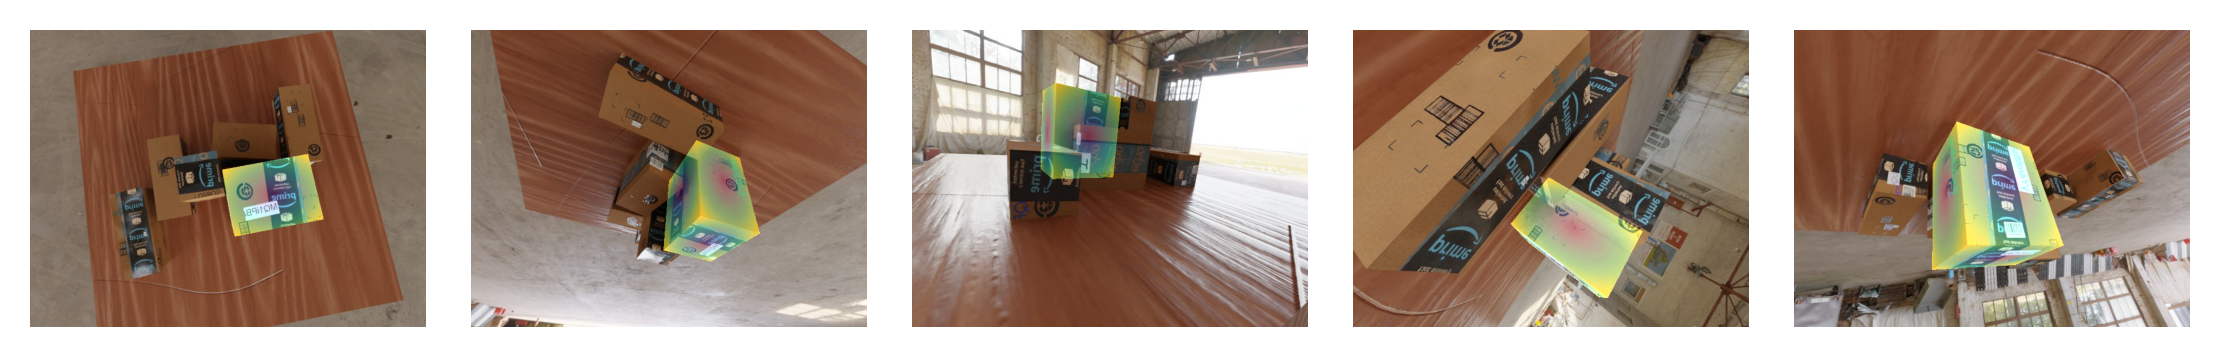

In [52]:
# Render the ground-truth descriptor image for each picture.
rendered_hypothesis_descriptor_images = []
plt.figure(dpi=300).set_size_inches(2*len(all_examples)*(480/640.), 2)
for k, example in enumerate(all_examples):
    im = render_single_box_descriptor_image(
        target_box_pose, target_box_shape,
        transform_from_pose_vector(example["camera_pose"]),
        example["camera_calibration"]
    )
    rendered_hypothesis_descriptor_images.append(im)
    overlayed_im = example["image"].detach().cpu().numpy().copy().transpose([1, 2, 0])/255
    overlayed_im = cv2.cvtColor(overlayed_im, cv2.COLOR_BGR2RGB)
    blend_im = im[:, :, :3].copy()
    blend_im *= np.tile(im[:, :, 3:]*0.5, (1, 1, 3))
    plt.subplot(1, len(all_examples), k + 1)
    plt.imshow(np.clip(blend_im + overlayed_im, 0., 1.))
    plt.axis(False)
plt.tight_layout()

Score:  0.16696650160207963
Score:  0.1417291387574821
Score:  0.36128862193749783
Score:  0.39499154487032145
Score:  0.17307534579952955


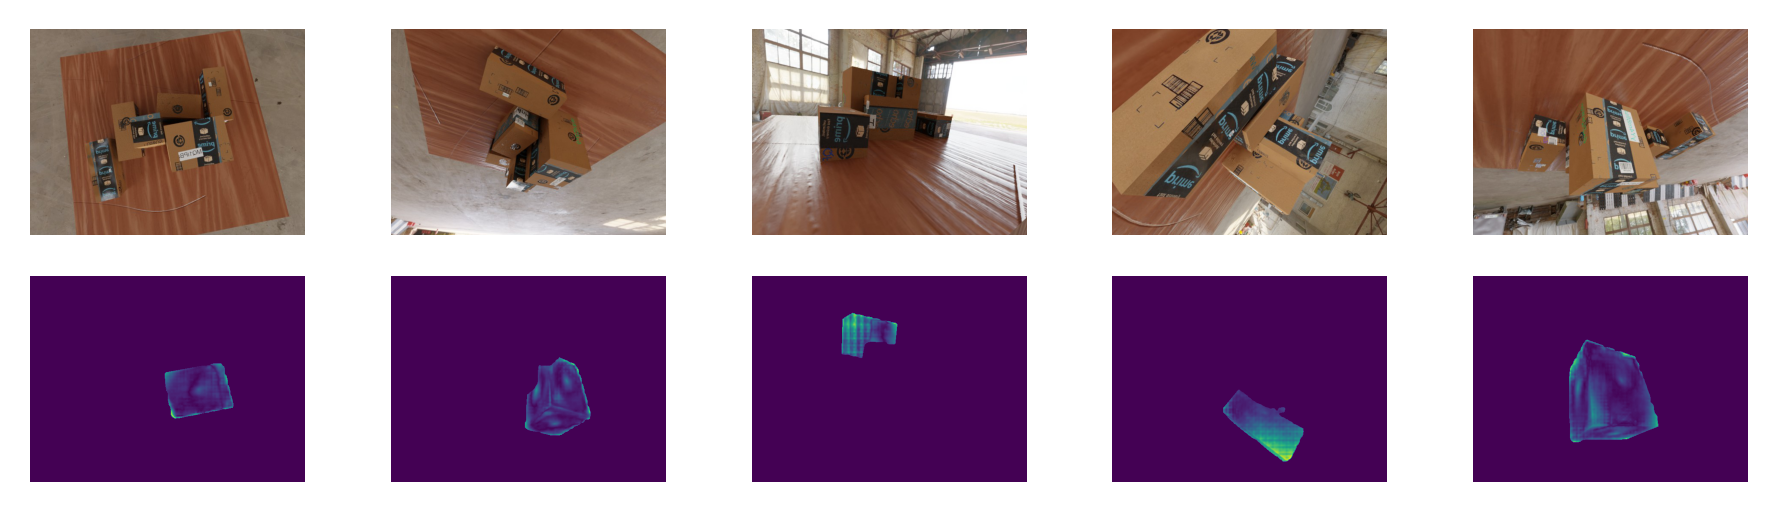

In [8]:
# For each image, calculate an inlier mask by finding the detection
# that the mask most overlaps with and intersecting with it.
def build_inlier_mask(example, hyp_desc_im):
    inlier_mask = hyp_desc_im[:, :, 3] != 0
    best_detection_overlap_amount = -1
    best_detection_overlap_ind = None
    best_detection_mask = None
    for pred_instance_k in range(len(example["prediction"]["instances"])):
        mask = example["prediction"]["instances"].pred_masks[pred_instance_k, ...].detach().cpu().numpy()
        intersection = np.sum(inlier_mask * mask)
        if intersection > best_detection_overlap_amount:
            best_detection_overlap_amount = intersection
            best_detection_mask = mask
            best_detection_overlap_ind = pred_instance_k
    return inlier_mask * best_detection_mask
    
plt.figure(dpi=300).set_size_inches(2*len(all_examples)*(480/640.), 2)
for example_k, example in enumerate(all_examples):
    hyp_desc_im = rendered_hypothesis_descriptor_images[example_k]
    inlier_mask = build_inlier_mask(example, hyp_desc_im)
    im = example["image"].detach().cpu().numpy().copy().transpose([1, 2, 0])/255
    plt.subplot(2, len(all_examples), example_k + 1)
    cv2_imshow(im)
    plt.subplot(2, len(all_examples), example_k + 1 + len(all_examples))
    real_descriptor_im = example["descriptor_im"].detach().cpu().permute([1, 2, 0]).numpy()
    err_im = np.linalg.norm(hyp_desc_im[:, :, :3] - real_descriptor_im, axis=-1)
    err_im[~inlier_mask] = 0
    plt.imshow(err_im)
    print("Score: ", np.mean(err_im[inlier_mask]))
    plt.axis(False)
    

In [95]:
from scipy.stats import beta as beta_dist
occlusion_dist = beta_dist(a=0.6025, b=0.2306)
def score_pose_and_shape(pose_tf, shape):
    scores = []
    for example_k, example in enumerate(all_examples):
        hyp_desc_im = render_single_box_descriptor_image(
            pose_tf, shape,
            transform_from_pose_vector(example["camera_pose"]),
            example["camera_calibration"]
        )
        inlier_mask = build_inlier_mask(example, hyp_desc_im)
        real_descriptor_im = example["descriptor_im"].detach().cpu().permute([1, 2, 0]).numpy()
        err_im = np.linalg.norm(hyp_desc_im[:, :, :3] - real_descriptor_im, axis=-1)
        err_im[~inlier_mask] = 0
        
        # P(im_observed) = P(unoccluded_pixels | occlusion details) * P(occlusion_details)
        # P(unoccluded_pixels | foreground mask) is just independent normal under the foreground mask
        # P(occlusion_details) could be based on occlusion %, which I could check out empirically.
        occlusion_ratio = float(np.sum(inlier_mask)) / float(np.sum(hyp_desc_im[:, :, 3]))
        clipped_occlusion_ratio = np.clip(occlusion_ratio, 0., 1.)
        if np.abs(occlusion_ratio - clipped_occlusion_ratio) > 1E-3:
            print("Warning: bug somewhere, occlusion ratio was way outside of [0, 1]: %f" % occlusion_ratio)
        occlusion_score = occlusion_dist.pdf(clipped_occlusion_ratio)
        # Hmm, sum or mean? I feel like this should be normalized.
        inliers_score = np.mean(err_im[inlier_mask])
        scores.append(occlusion_score * inliers_score)
    return np.array(scores)

# Evaluate some perturbations of a perfect fit
scores = []
vertical_perturbations = np.linspace(-0.1, 0.1, 10)
for vertical_perturbation in tqdm(vertical_perturbations):
    perturbed_pose = target_box_pose.copy()
    perturbed_pose[1, 3] += vertical_perturbation
    scores.append(
        score_pose_and_shape(perturbed_pose, target_box_shape)
    )
scores = np.vstack(scores)

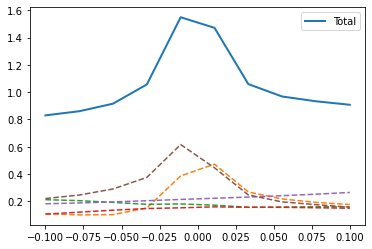

In [96]:
score_sums = np.sum(scores, axis=1)
plt.plot(vertical_perturbations, score_sums, label="Total", linewidth=2)
for k in range(scores.shape[1]):
    plt.plot(vertical_perturbations, scores[:, k], linestyle="--")
plt.legend()

In [78]:
# Investigate empirical distribution of occlusion % per-object.
data_file = "mask_statistics_over_5types_dataset.npy"
def do_runs():
    intersection_totals = []
    union_totals = []
    segmentation_totals = []
    predicted_mask_totals = []
    for batch_ndx, samples in tqdm(enumerate(test_loader)):
        for example in samples:
            this_cam_pose = rigidtransform_from_pose_vector(example["camera_pose"])
            for instance_k in range(len(example["instances"])):
                # Visible, occluded pixels
                instance = example["instances"][instance_k]
                segmentation_mask = instance.gt_masks.tensor.cpu().numpy()
                segmentation_totals.append(np.sum(segmentation_mask))
                
                # Pixels that *should* be visible with no occlusions
                this_box_shape = instance.gt_shape_params.numpy().flatten()
                this_box_pose_cam = rigidtransform_from_pose_vector(
                    instance.gt_pose_quatxyz.numpy().flatten())
                # TF to world frame
                this_box_pose = this_cam_pose.multiply(this_box_pose_cam).GetAsMatrix4()
                hyp_desc_im = render_single_box_descriptor_image(
                    this_box_pose, this_box_shape,
                    this_cam_pose.GetAsMatrix4(),
                    example["camera_calibration"]
                )
                predicted_mask_totals.append(np.sum(hyp_desc_im[:, :, 3] != 0))
                intersection_mask = hyp_desc_im[:, :, 3] * segmentation_mask
                intersection_totals.append(np.sum(intersection_mask))
                union_mask = (hyp_desc_im[:, :, 3] + segmentation_mask) != 0
                union_totals.append(np.sum(union_mask))

        # A full run takes ~20 mins.
        # But you can get a good approx sense with just a few examples (minute or two).
        if batch_ndx > 100:
           break
    return (
        np.array(intersection_totals), 
        np.array(union_totals), 
        np.array(segmentation_totals),
        np.array(predicted_mask_totals),
    )
if 1 or not os.path.exists(data_file):
    print("Doing runs")
    data = do_runs()
    np.save(data_file, data)
intersection_totals, union_totals, segmentation_totals, predicted_mask_totals = np.load(data_file)

Doing runs


Fit params for IOU: Alpha 0.739446, Beta 0.324472, loc 0.000000, Scale 1.000000
Fit params for Intersect Over Seg: Alpha 193.194375, Beta 0.647368, loc 0.000000, Scale 1.000000
Fit params for Intersect Over Pred Mask: Alpha 0.693376, Beta 0.290277, loc 0.000000, Scale 1.000000


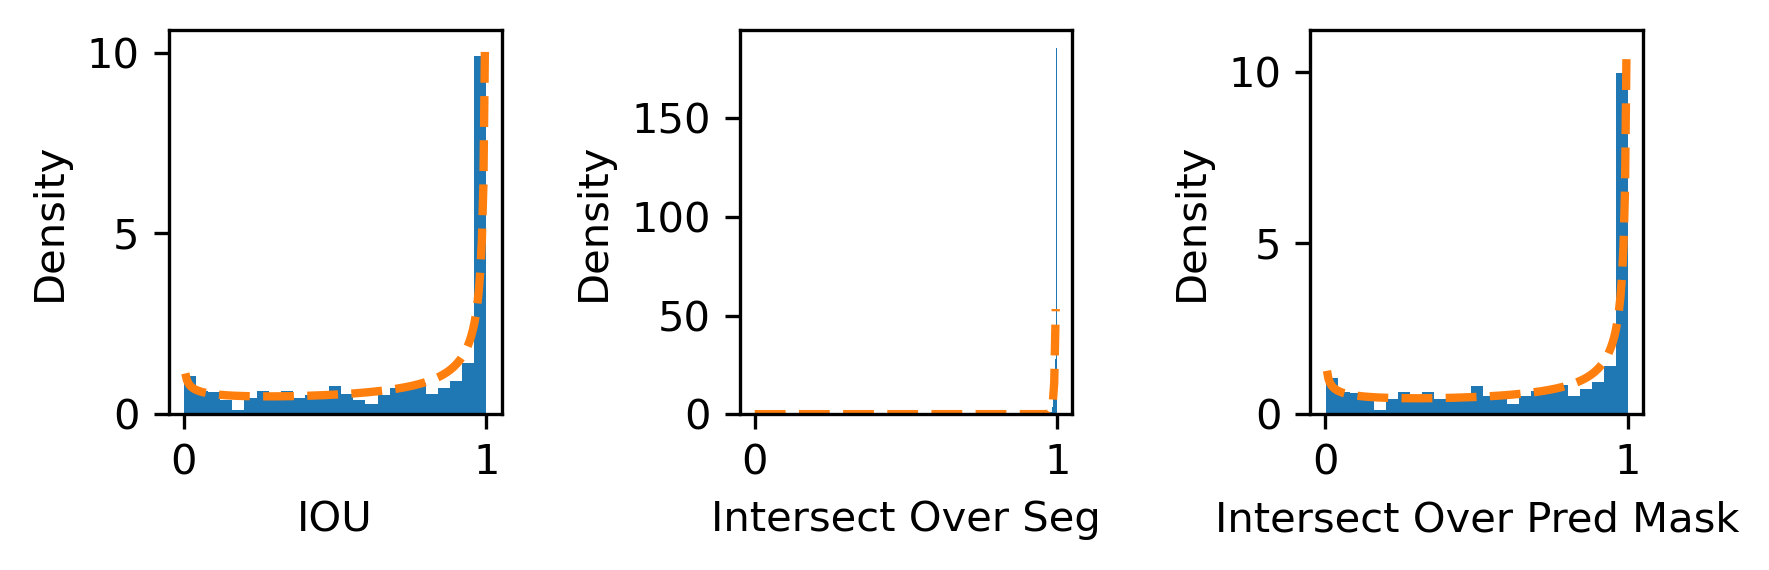

In [94]:
ious = intersection_totals / union_totals
intersection_over_segmentation = intersection_totals / segmentation_totals
intersection_over_pred_mask = intersection_totals / predicted_mask_totals
def do_beta_fit_and_plot(data, name):
    clipped_data = np.clip(data, 1E-4, 1. - 1E-4)
    if np.max(np.abs(clipped_data - data)) > 1E-3:
        print("Warning: clipping to [0, 1] changed data a lot.")
    plt.hist(clipped_data, density=True, bins=25)
    plt.xlabel(name)
    plt.ylabel("Density")
    from scipy.stats import beta as beta_dist
    alpha, beta, loc, scale = beta_dist.fit(clipped_data, floc=0, fscale=1)
    x = np.linspace(0., 1., 200)
    print("Fit params for %s: Alpha %f, Beta %f, loc %f, Scale %f" % (name, alpha, beta, loc, scale))
    plt.plot(x, beta_dist(alpha, beta, loc, scale).pdf(x), linewidth=2, linestyle="--")
    # Looks like the beta dist is pretty good, but may under-count at 100%.
    # I think this effects might be OK... I'll roll with this for now.
    # From my full run on occlusion_percents_5types_dataset:
    #  Alpha 0.6, Beta 0.23.

plt.figure(dpi=300).set_size_inches(6, 2)
plt.subplot(1, 3, 1)
do_beta_fit_and_plot(ious, "IOU")
plt.subplot(1, 3, 2)
do_beta_fit_and_plot(intersection_over_segmentation, "Intersect Over Seg")
plt.subplot(1, 3, 3)
do_beta_fit_and_plot(intersection_over_pred_mask, "Intersect Over Pred Mask")
plt.tight_layout()